# Vertex Cover

### Definition

We are given an undirected graph with vertex set $V$ and edge set $E$.

Our aim is to find the smallest number of nodes to be coloured, such that every edge has a coloured vertex. Also, which vertices would these be? 

### Applications

The Vertex Cover has applications in matching problems and optimization problems in fields like Biochemistry, Computational Biology, Monitoring and Computer Network Security.

### Path to solving the problem
Vertex Cover is a minimization problem and its cost function can be cast to a QUBO problem through its respective Hamiltonian (see the [Introduction](./introduction.ipynb) and a [reference](https://arxiv.org/abs/1302.5843)),

$$ \displaystyle \large
H = A \textstyle\sum\limits_{uv \in E}  (1 - x_u) (1 - x_v) + B \textstyle\sum\limits_{v} x_v
$$

where $A$ and $B$ are positive constants, $u, v \in V$ and $x_u$ is a binary variable, which is $1$ if vertex $u$ is part of the Vertex Cover and $0$ if it is not. For a valid encoding, the $A$ and $B$ constants need to obey the relation $A > B$. 
Otherwise, if this rule is not followed, the spin configuration for the lowest energy $H$ may not correspond to the best solution of our Vertex Cover problem or even to a valid one. At the same time $A \gg B$ would not be desired, as it would cause a large energy separation in $H$, impeding our solution approach.

The myQLM allows us to encode a problem in this Hamiltonian form by using the `VertexCover` class for a given graph and constants $A$ and $B$. We can then create a job from the problem and send it to a Simulated Annealer (SA) wrapped with a Quantum Processing Unit (QPU) interface. The SA will minimize the Hamiltonian, hence we find the solution to our problem.

In fact, the QLM contains an even more powerful solver $-$ Simulated Quantum Annealing (SQA). This quantum annealer has been tested on numerous benchmarks for the NP problems supported and produces results with a quality usually exceeding $98\%$. More details can be found in the [documentation](https://myqlm.github.io/advanced_combinatorial_optimization.html#simulated-quantum-annealing-benchmarking-and-performance).

### Quantum complexity

To represent the problem as QUBO, myQLM would need $N$ spins $-$ to encode each of the $N$ vertices. 

# Example problem

Imagine we are given a graph with $6$ vertices and $6$ edges, as shown below (left). The solution of this problem is quite easy to guess $-$ we can simply colour node $0$ and either node $1$ or node $5$ (right).

<br><img src="./vertex_cover_example_solution.png" style="width: 850px"><br>

However, let's describe a method, which will enable us to find the Vertex Cover of any graph!

We shall start by specifying a graph with the `networkx` library along with the constants $A$ and $B$.

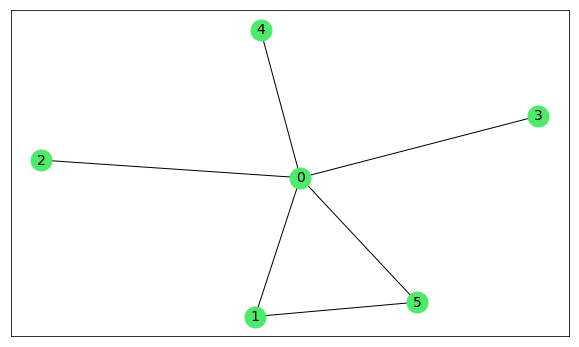

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Specify the graph 
# First example
graph = nx.Graph()
graph.add_nodes_from(np.arange(6))
graph.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5)])

# # Second example
# graph = nx.gnm_random_graph(15, 30)

# Impose constraints for the right encoding
B = 1
A = B + 0.01

# Draw the graph
nodes_positions = nx.spring_layout(graph, iterations=len(graph.nodes())*60)
plt.figure(figsize=(10, 6))
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 node_color='#4EEA6A', 
                 node_size=440, 
                 font_size=14)
plt.show()

Once the graph is specified and the constants $A$ and $B$ correctly chosen, we can encode the problem via our `VertexCover` class:

In [3]:
from qat.opt import VertexCover

vertex_cover_problem = VertexCover(graph, A=A, B=B)

# Solution

We can now proceed to compute the solution of the problem by the following procedure:

1. Extract some fine-tuned parameters for VertexCover (found for SQA) which are needed for the temperature schedule.


2. Create the temperature schedule using the `t` time variable (instance of the class `Variable`) and thus the `SimulatedAnnealing` QPU.


3. Create a job from the problem by calling the `to_job()` method and send it to the QPU.


4. Extract the `Result` and present the solution spin configuration.


5. Show the graph with the coloured nodes.

Each spin from the solution configuration corresponds to a node from the graph at the same position. Note that if the numbering of the input nodes starts from $1$ and not from $0$, one still needs to look at the $0$th spin to extract information for this first node, numbered as $1$.

When a spin has the value of $1$, this means that the respective node should be coloured and is part of the Vertex Cover. 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: gamma_t is needed for SQA.


Solution configuration: 
[ 1.  1. -1. -1. -1. -1.]

One would need to colour 2 vertices, which are:
[0 1]



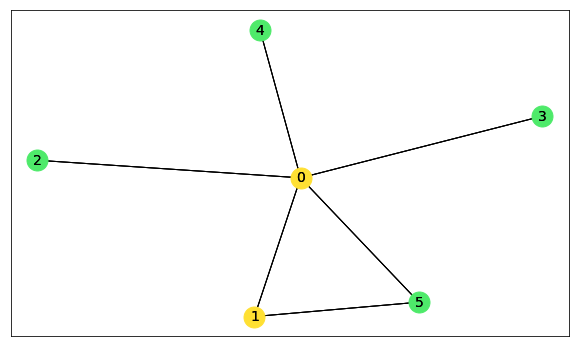

In [4]:
from qat.qpus import SimulatedAnnealing
from qat.simulated_annealing import integer_to_spins
from qat.core import Variable

# 1. Extract parameters for SA
problem_parameters_dict = vertex_cover_problem.get_best_parameters()
n_steps = problem_parameters_dict["n_steps"]
temp_max = problem_parameters_dict["temp_max"]
temp_min = problem_parameters_dict["temp_min"]

# 2. Create a temperature schedule and a QPU
tmax = 1.0
t = Variable("t", float)
temp_t = temp_min * (t / tmax) + temp_max * (1 - t / tmax)
sa_qpu = SimulatedAnnealing(temp_t=temp_t, n_steps=n_steps)

# 3. Create a job and send it to the QPU
problem_job = vertex_cover_problem.to_job(tmax=tmax)
problem_result = sa_qpu.submit(problem_job)

# 4. Extract and print the solution configuration
state = problem_result.raw_data[0].state.int  # raw_data is a list of Samples - one per computation
solution_configuration = integer_to_spins(state, len(graph.nodes()))
print("Solution configuration: \n" + str(solution_configuration) + "\n")
indices_spin_1 = np.where(solution_configuration == 1)[0]
number_of_colours = len(indices_spin_1)
print("One would need to colour " + "\033[1m" + str(number_of_colours) + 
      "\033[0;0m" + " vertices, which are:\n" + str(indices_spin_1) + "\n")

# 5. Show the coloured graph
plt.figure(figsize=(10, 6))
node_size = 440
font_size = 14
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_1.tolist(), 
                 node_color='#FFE033', 
                 node_size=node_size, 
                 font_size=font_size)

indices_spin_minus_1 = np.where(solution_configuration == -1)[0]
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_minus_1.tolist(), 
                 node_color='#4EEA6A', 
                 node_size=node_size, 
                 font_size=font_size)
nx.draw_networkx_edges(graph, pos=nodes_positions)
plt.show()

# Solution analysis

For graphs which are quite big, one may find it hard to examine visually the solution. Therefore, here is a simple check for this purpose $-$ whether each edge has a coloured vertex and if not $-$ a list of colourless edges.

In [5]:
colourless_edges_list = []
for (node_i, node_j) in graph.edges():
    if node_i not in indices_spin_1 and node_j not in indices_spin_1:
        colourless_edges_list.append((node_i, node_j))
if len(colourless_edges_list) == 0:
    print ("The graph is covered well !")
else:
    print("The " + "\033[1m" + str(len(colourless_edges_list)) + 
          "\033[0;0m" + " edges without coloured nodes are:")
    print("(node, node)")
    for edge in colourless_edges_list: print(edge)

The graph is covered well !
